In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [2]:
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoSegmentationDataset(Dataset):
    # Init function: loads annotation file and prepares list of image id's
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        root_dir: path to the folder containing images (e.g. car_parts_dataset/train/)
        annotation_file: path to the COCO annotations (e.g. car_parts_dataset/train/_annotations.coco.json)
        """
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
    
    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")
        
        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)
        
         # Extract segmentation masks,bounding boxes and labels from annotations
        boxes = []
        labels = []
        masks = []
        
        for ann in annotations:
            xmin, ymin, w, h = ann['bbox']
            xmax = xmin + w
            ymax = ymin + h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
            mask = self.coco.annToMask(ann)
            masks.append(mask)
        
        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = torch.as_tensor([ann['area'] for ann in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in annotations], dtype=torch.int64)
        
        # store everything in a dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms
        if self.transforms:
            image = self.transforms(image)
        
         # Return the processed image and its annotations
        return image, target

In [3]:
import os
os.getcwd()

'/run/media/shared_storage/Documents/KuliahUbS1/Semester11_2025_2026/A_Pengolahan_Citra_Digital_dan_Visi_Komputer/tugas_kel_pcdvk/proyek_akhir'

In [4]:
os.listdir('apple_leaf_dataset/rcnn/valid_coco')

['images', 'result.json']

In [5]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# convert a PIL image to a PyTorch tensor
def get_transform():
    return ToTensor()

train_dataset = CocoSegmentationDataset(
    root_dir='apple_leaf_dataset/rcnn/train_coco/images',
    annotation_file='apple_leaf_dataset/rcnn/train_coco/result.json',
    transforms=get_transform()  # define this if needed
)

valid_dataset = CocoSegmentationDataset(
    root_dir='apple_leaf_dataset/rcnn/valid_coco/images',
    annotation_file='apple_leaf_dataset/rcnn/valid_coco/result.json',
    transforms=get_transform()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
# Label list 
CLASS_NAMES = [
    "Apple___Apple_scab", "Apple___Black_rot", "Apple___Cedar_apple_rust", "Leaf"
]


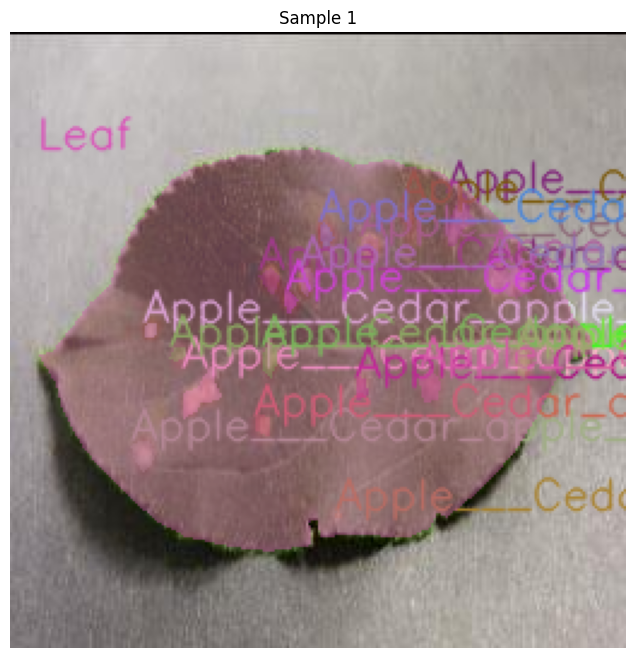

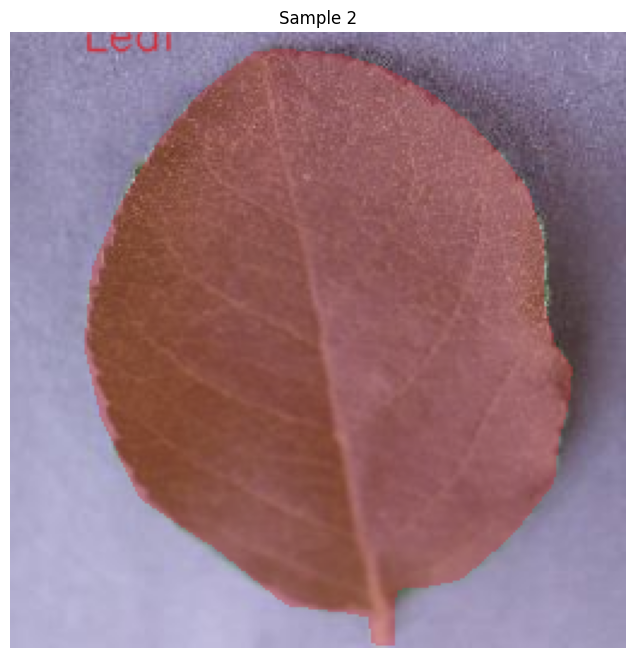

In [14]:
# Sample a batch
images, targets = next(iter(train_loader))

for i in range(len(images)):
    # Convert image tensor to numpy array
    image = images[i].permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    overlay = image.copy()
    
    # Extract masks, bounding boxes, and labels for the current image
    masks = targets[i]['masks'].cpu().numpy()
    boxes = targets[i]['boxes'].cpu().numpy()
    labels = targets[i]['labels'].cpu().numpy()

    for j in range(len(masks)):
        mask = masks[j]
        box = boxes[j]
        label_id = labels[j]

        # Get class name from mapping
        class_name = CLASS_NAMES[label_id]  # assuming 0-based labels

        # Random color
        color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

        # Alpha blend mask
        colored_mask = np.zeros_like(image, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        alpha = 0.4
        overlay = np.where(mask[..., None], 
                           ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8), 
                           overlay)

        # Draw label
        x1, y1, x2, y2 = map(int, box)
        cv2.putText(overlay, class_name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, color, 1, lineType=cv2.LINE_AA)


    # Show the result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Sample {i + 1}")
    plt.show()